In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.figsize'] = (12,8)
mpl.rcParams['font.size'] = 12
mpl.rcParams['figure.dpi'] = 80
import seaborn as sns
sns.set_style("darkgrid")
mpl.style.use('ggplot')

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

# Location of the building


In [ ]:
import geopandas as gpd
from shapely.geometry import Point, Polygon

In [ ]:
data = pd.read_csv("metadata.csv")
data

,building_id,site_id,building_id_kaggle,site_id_kaggle,primaryspaceusage,sub_primaryspaceusage,sqm,sqft,lat,lng,...,yearbuilt,date_opened,numberoffloors,occupants,energystarscore,eui,site_eui,source_eui,leed_level,rating
0,Panther_lodging_Dean,Panther,NaN,0.0,Lodging/residential,Residence Hall,508.8,5477.0,28.517689,-81.379039,...,1989.0,NaN,NaN,NaN,NaN,271,NaN,NaN,None,NaN
1,Panther_lodging_Shelia,Panther,NaN,0.0,Lodging/residential,Residence Hall,929.0,10000.0,28.517689,-81.379039,...,1992.0,NaN,NaN,NaN,NaN,62,NaN,NaN,None,NaN
2,Panther_lodging_Ricky,Panther,NaN,0.0,Lodging/residential,Residence Hall,483.1,5200.0,28.517689,-81.379039,...,2016.0,NaN,NaN,NaN,NaN,534,NaN,NaN,None,NaN
3,Panther_education_Rosalie,Panther,0.0,0.0,Education,Research,690.5,7432.0,28.517689,-81.379039,...,2008.0,NaN,NaN,NaN,NaN,276,NaN,NaN,None,NaN
4,Panther_education_Misty,Panther,1.0,0.0,Education,Research,252.7,2720.0,28.517689,-81.379039,...,2004.0,NaN,NaN,NaN,NaN,375,NaN,NaN,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1631,Mouse_health_Estela,Mouse,NaN,NaN,Healthcare,Hospital,17193.0,185064.0,51.521939,-0.120069,...,1936.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,F
1632,Mouse_health_Ileana,Mouse,NaN,NaN,Healthcare,Hospital,5399.0,58114.0,51.521939,-0.120069,...,1954.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,F
1633,Mouse_health_Buddy,Mouse,NaN,NaN,Healthcare,Hospital,1749.0,18826.0,51.521939,-0.120069,...,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,F
1634,Mouse_lodging_Vicente,Mouse,NaN,NaN,Lodging/residential,Hotel,3489.0,37555.0,51.521939,-0.120069,...,2006.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,F


In [ ]:
# showing the building on world map
#path to geopanda dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Exclude Antartica
world = world[(world.name != "Antarctica") & (world.name != "Fr. S. Antarctic Lands")]
# Coordinate reference system used in this map
world.crs

<ipython-input-5-844963b3b2e5>:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
#latitude and longitude are of the site location (all buildings from the same location shares lng and lat values).
# All the sites
site = data[["site_id","lat","lng"]].groupby("site_id").median()
# Converts lat and lng to geometry objects
geometry = [Point(xy) for xy in zip (site["lng"], site["lat"])]
# Creates geoDataFrame
geodata = gpd.GeoDataFrame(site, crs = world.crs, geometry = geometry)
geodata

/usr/local/lib/python3.10/dist-packages/geopandas/geoseries.py:751: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


,lat,lng,geometry
site_id,,,
Bear,37.871903,-122.260729,POINT (-122.26073 37.87190)
Bobcat,NaN,NaN,POINT EMPTY
Bull,30.267200,-97.743100,POINT (-97.74310 30.26720)
Cockatoo,42.459837,-76.485292,POINT (-76.48529 42.45984)
Crow,45.387600,-75.696000,POINT (-75.69600 45.38760)
Eagle,NaN,NaN,POINT EMPTY
Fox,33.424425,-111.928140,POINT (-111.92814 33.42443)
Gator,NaN,NaN,POINT EMPTY
Hog,44.978782,-93.255398,POINT (-93.25540 44.97878)


(5.0, 75.0)

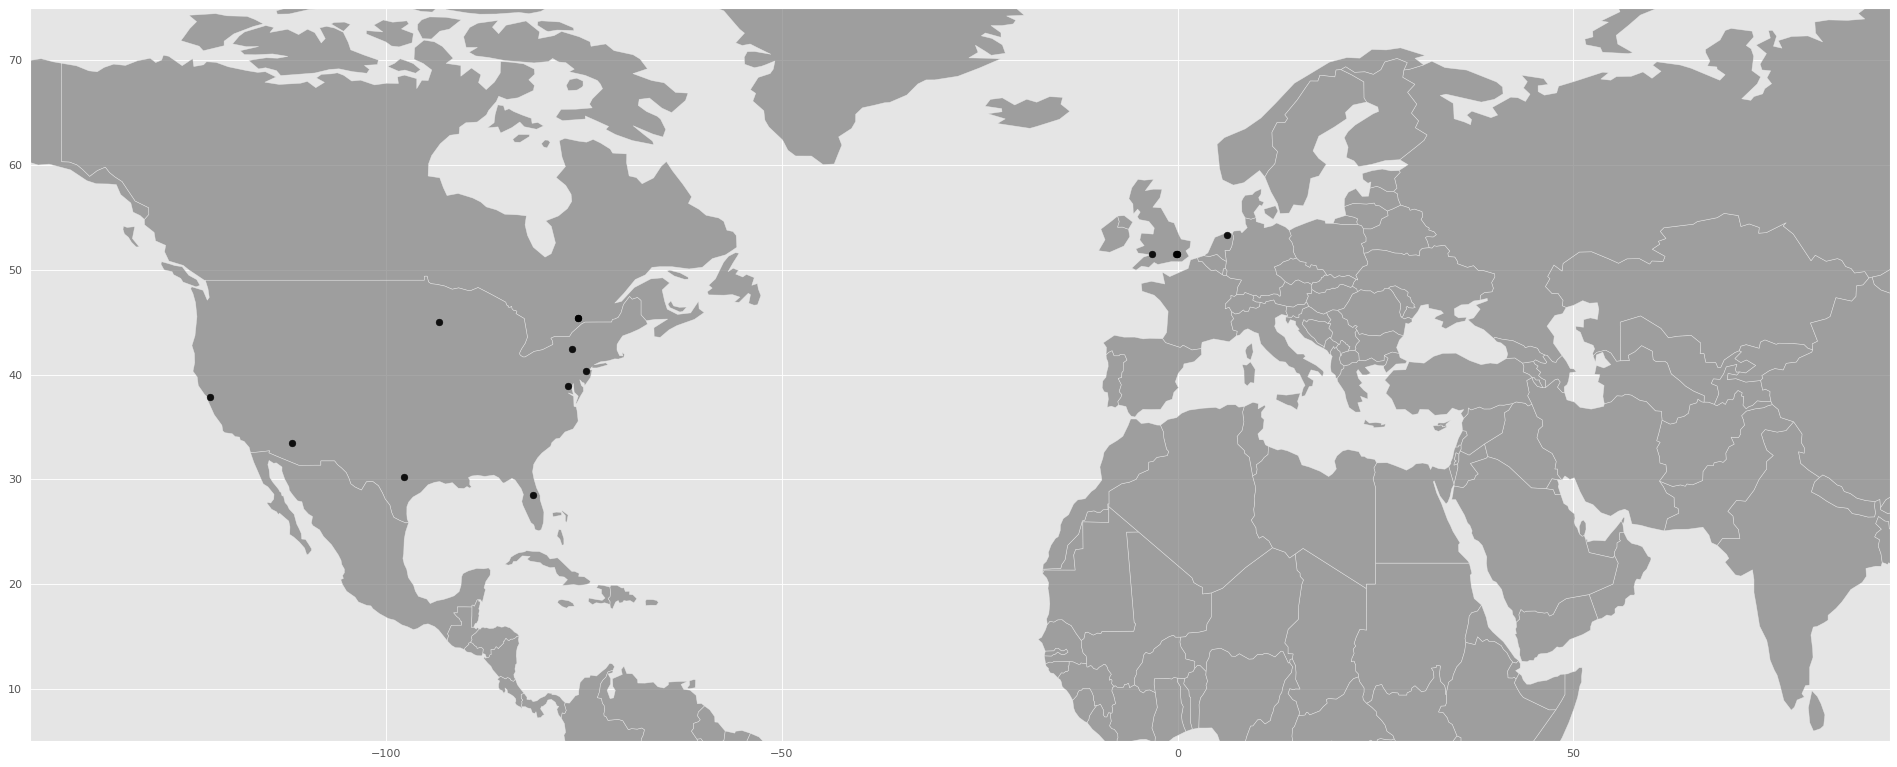

In [ ]:
# Zoom Plot
figure, ax = plt.subplots(figsize = (30,40))
world.plot(ax = ax, alpha = 0.7, color = "grey")
geodata.plot(ax = ax, alpha = 0.9, color = "black")
ax.set_xlim([-145, 90])
ax.set_ylim([5, 75])

In [ ]:
data_new = data[data['building_id']=='Wolf_education_Dorris']

In [ ]:
# showing the building on world map
#path to geopanda dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Exclude Antartica
world = world[(world.name != "Antarctica") & (world.name != "Fr. S. Antarctic Lands")]
# Coordinate reference system used in this map
world.crs

<ipython-input-34-844963b3b2e5>:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
#latitude and longitude are of the site location (all buildings from the same location shares lng and lat values).
# All the sites
site = data_new[["site_id","lat","lng"]].groupby("site_id").median()
# Converts lat and lng to geometry objects
geometry = [Point(xy) for xy in zip (site["lng"], site["lat"])]
# Creates geoDataFrame
geodata = gpd.GeoDataFrame(site, crs = world.crs, geometry = geometry)
geodata

,lat,lng,geometry
site_id,,,
Wolf,53.3498,6.2603,POINT (6.26030 53.34980)


(25.0, 70.0)

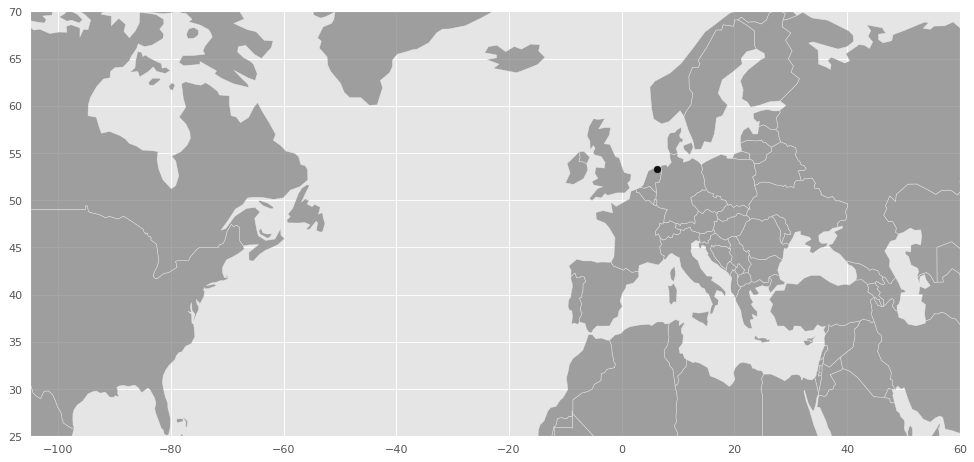

In [ ]:
# Groningen, Netherlands.
figure, ax = plt.subplots(figsize = (15,30))
world.plot(ax = ax, alpha = 0.7, color = "grey")
geodata.plot(ax = ax, alpha = 0.9, color = "black")
ax.set_xlim([-105, 60])
ax.set_ylim([25, 70])

# Steam dataset

In [ ]:
df = pd.read_csv('water.csv')
df.head()

,timestamp,Panther_lodging_Cora,Panther_office_Hannah,Panther_lodging_Hattie,Panther_education_Teofila,Panther_education_Jerome,Panther_retail_Felix,Panther_parking_Asia,Panther_lodging_Heather,Panther_education_Misty,...,Wolf_education_Loren,Wolf_education_Roderick,Wolf_education_Josefa,Wolf_education_Dorris,Wolf_retail_Toshia,Wolf_retail_Harriett,Wolf_office_Bobbie,Wolf_education_Miguel,Wolf_assembly_Elaine,Wolf_education_Ursula
0,2016-01-01 00:00:00,378.541,0.0,13248.935,0.3785,75.7082,378.541,0.0,0.0,0.0,...,63.4013,0.0,2.6417,0.0,0.0,3.9626,5.2834,31.7006,96.9511,44.9092
1,2016-01-01 01:00:00,378.541,0.0,13248.935,0.3785,75.7082,378.541,0.0,0.0,0.0,...,63.4013,0.0,1.3209,0.0,0.0,5.2834,7.9252,34.3424,96.4228,42.2675
2,2016-01-01 02:00:00,757.082,0.0,12870.394,0.0000,75.7082,378.541,0.0,0.0,0.0,...,68.6847,0.0,2.6417,0.0,0.0,3.9626,10.5669,31.7006,96.6870,44.9092
3,2016-01-01 03:00:00,757.082,0.0,13248.935,0.3785,75.7082,378.541,0.0,0.0,NaN,...,60.7596,0.0,2.6417,0.0,0.0,3.9626,13.2086,200.7707,96.4228,44.9092
4,2016-01-01 04:00:00,757.082,0.0,13627.476,0.0000,75.7082,757.082,0.0,0.0,0.0,...,68.6847,0.0,1.3209,0.0,0.0,3.9626,10.5669,31.7006,97.4795,44.9092


In [ ]:
df.isnull().sum()

timestamp                     0
Panther_lodging_Cora         14
Panther_office_Hannah        37
Panther_lodging_Hattie       14
Panther_education_Teofila    14
                             ..
Wolf_retail_Harriett          8
Wolf_office_Bobbie            2
Wolf_education_Miguel         1
Wolf_assembly_Elaine          2
Wolf_education_Ursula         4
Length: 147, dtype: int64

In [ ]:
df.fillna(df.median(), inplace = True)

<ipython-input-39-6d32324f46c9>:1: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.fillna(df.median(), inplace = True)


In [ ]:
df.isnull().sum()

timestamp                    0
Panther_lodging_Cora         0
Panther_office_Hannah        0
Panther_lodging_Hattie       0
Panther_education_Teofila    0
                            ..
Wolf_retail_Harriett         0
Wolf_office_Bobbie           0
Wolf_education_Miguel        0
Wolf_assembly_Elaine         0
Wolf_education_Ursula        0
Length: 147, dtype: int64

In [ ]:
dfw = pd.read_csv('weatherstats_ottawa_hourly.csv')
dfw

FileNotFoundError: [Errno 2] No such file or directory: 'weatherstats_ottawa_hourly.csv'

In [ ]:
dfw = dfw[['date_time_local', 'wind_dir_10s', 'dew_point', 'visibility', 'relative_humidity', 'wind_speed', 'temperature']]

In [ ]:
dfw['date_time_local'] = dfw['date_time_local'].str.replace(' EDT', '')
dfw['date_time_local'] = dfw['date_time_local'].str.replace(' EST', '')
dfw = dfw[(dfw['date_time_local'] >= '2016-01-01 00:00:00') & (dfw['date_time_local'] < '2018-01-01 00:00:00')]
dfw.date_time_local = pd.to_datetime(dfw.date_time_local)
dfw = dfw.set_index('date_time_local')
dfw.sort_index(inplace=True)
dfw

C:\Users\Aida\AppData\Local\Temp/ipykernel_14304/3574609087.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfw['date_time_local'] = dfw['date_time_local'].str.replace(' EDT', '')
C:\Users\Aida\AppData\Local\Temp/ipykernel_14304/3574609087.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfw['date_time_local'] = dfw['date_time_local'].str.replace(' EST', '')


,wind_dir_10s,dew_point,visibility,relative_humidity,wind_speed,temperature
date_time_local,,,,,,
2016-01-01 00:00:00,26.0,-3.8,24100.0,91.0,10,-2.5
2016-01-01 01:00:00,25.0,-4.1,6400.0,90.0,10,-2.7
2016-01-01 02:00:00,25.0,-4.3,4800.0,92.0,6,-3.2
2016-01-01 03:00:00,26.0,-4.2,4800.0,94.0,5,-3.4
2016-01-01 04:00:00,22.0,-4.5,6400.0,95.0,6,-3.8
...,...,...,...,...,...,...
2017-12-31 19:00:00,28.0,-26.9,24100.0,61.0,18,-21.4
2017-12-31 20:00:00,28.0,-27.1,24100.0,63.0,13,-21.9
2017-12-31 21:00:00,28.0,-26.8,24100.0,65.0,14,-21.9


In [ ]:
dfw.visibility = dfw['visibility'].interpolate(option='spline')

In [ ]:
dfw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17544 entries, 2016-01-01 00:00:00 to 2017-12-31 23:00:00
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   wind_dir_10s       17544 non-null  float64
 1   dew_point          17544 non-null  float64
 2   visibility         17544 non-null  float64
 3   relative_humidity  17544 non-null  float64
 4   wind_speed         17544 non-null  int64  
 5   temperature        17544 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 959.4 KB


In [ ]:
df = df [['timestamp', 'Moose_education_Ricardo']]
df.rename(columns={'Moose_education_Ricardo': 'steam'}, inplace=True)

df.timestamp = pd.to_datetime(df.timestamp)
df = df.set_index('timestamp')
df.sort_index(inplace=True)
df

,steam
timestamp,
2016-01-01 00:00:00,1500.80
2016-01-01 01:00:00,1446.00
2016-01-01 02:00:00,1427.20
2016-01-01 03:00:00,1443.63
2016-01-01 04:00:00,1452.00
...,...
2017-12-31 19:00:00,1767.99
2017-12-31 20:00:00,1781.48
2017-12-31 21:00:00,1814.81


In [ ]:
dfw.reset_index(inplace=True)
df.reset_index(inplace=True)

In [ ]:
dfw

,date_time_local,wind_dir_10s,dew_point,visibility,relative_humidity,wind_speed,temperature
0,2016-01-01 00:00:00,26.0,-3.8,24100.0,91.0,10,-2.5
1,2016-01-01 01:00:00,25.0,-4.1,6400.0,90.0,10,-2.7
2,2016-01-01 02:00:00,25.0,-4.3,4800.0,92.0,6,-3.2
3,2016-01-01 03:00:00,26.0,-4.2,4800.0,94.0,5,-3.4
4,2016-01-01 04:00:00,22.0,-4.5,6400.0,95.0,6,-3.8
...,...,...,...,...,...,...,...
17539,2017-12-31 19:00:00,28.0,-26.9,24100.0,61.0,18,-21.4
17540,2017-12-31 20:00:00,28.0,-27.1,24100.0,63.0,13,-21.9
17541,2017-12-31 21:00:00,28.0,-26.8,24100.0,65.0,14,-21.9
17542,2017-12-31 22:00:00,27.0,-27.3,24100.0,70.0,8,-23.2


In [ ]:
df2 = pd.merge(df, dfw, how='inner', left_on = 'timestamp', right_on = 'date_time_local')
df2

,timestamp,steam,date_time_local,wind_dir_10s,dew_point,visibility,relative_humidity,wind_speed,temperature
0,2016-01-01 00:00:00,1500.80,2016-01-01 00:00:00,26.0,-3.8,24100.0,91.0,10,-2.5
1,2016-01-01 01:00:00,1446.00,2016-01-01 01:00:00,25.0,-4.1,6400.0,90.0,10,-2.7
2,2016-01-01 02:00:00,1427.20,2016-01-01 02:00:00,25.0,-4.3,4800.0,92.0,6,-3.2
3,2016-01-01 03:00:00,1443.63,2016-01-01 03:00:00,26.0,-4.2,4800.0,94.0,5,-3.4
4,2016-01-01 04:00:00,1452.00,2016-01-01 04:00:00,22.0,-4.5,6400.0,95.0,6,-3.8
...,...,...,...,...,...,...,...,...,...
17539,2017-12-31 19:00:00,1767.99,2017-12-31 19:00:00,28.0,-26.9,24100.0,61.0,18,-21.4
17540,2017-12-31 20:00:00,1781.48,2017-12-31 20:00:00,28.0,-27.1,24100.0,63.0,13,-21.9
17541,2017-12-31 21:00:00,1814.81,2017-12-31 21:00:00,28.0,-26.8,24100.0,65.0,14,-21.9
17542,2017-12-31 22:00:00,1827.97,2017-12-31 22:00:00,27.0,-27.3,24100.0,70.0,8,-23.2


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17544 entries, 0 to 17543
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   timestamp          17544 non-null  datetime64[ns]
 1   steam              17544 non-null  float64       
 2   date_time_local    17544 non-null  datetime64[ns]
 3   wind_dir_10s       17544 non-null  float64       
 4   dew_point          17544 non-null  float64       
 5   visibility         17544 non-null  float64       
 6   relative_humidity  17544 non-null  float64       
 7   wind_speed         17544 non-null  int64         
 8   temperature        17544 non-null  float64       
dtypes: datetime64[ns](2), float64(6), int64(1)
memory usage: 1.3 MB


In [ ]:
df2.isnull().sum()

timestamp            0
steam                0
date_time_local      0
wind_dir_10s         0
dew_point            0
visibility           0
relative_humidity    0
wind_speed           0
temperature          0
dtype: int64

In [ ]:
 df2.set_index('timestamp', inplace = True)
 df2.drop('date_time_local', axis=1, inplace = True)


# Filling null values

In [ ]:
df2.fillna(df.median(), inplace = True)

C:\Users\Aida\AppData\Local\Temp/ipykernel_9520/2127929232.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df2.fillna(df.median(), inplace = True)


In [ ]:
df2.isnull().sum()

steam                0
wind_dir_10s         0
dew_point            0
visibility           0
relative_humidity    0
wind_speed           0
temperature          0
dtype: int64

# Feature Engineering

In [ ]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    df['weekofyear'] = df['weekofyear'].astype(int)
    return df

df = create_features(df2)

In [ ]:
import holidays
df['hols'] = pd.Series(df.index).apply(lambda x: holidays.Canada(years = [2016,2017]).get(x)).values

In [ ]:
df['hols'] = df['hols'].notnull().astype('int')

In [ ]:
df

,steam,wind_dir_10s,dew_point,visibility,relative_humidity,wind_speed,temperature,hour,dayofweek,quarter,month,dayofyear,dayofmonth,weekofyear,hols
timestamp,,,,,,,,,,,,,,,
2016-01-01 00:00:00,1500.80,26.0,-3.8,24100.0,91.0,10,-2.5,0,4,1,1,1,1,53,1
2016-01-01 01:00:00,1446.00,25.0,-4.1,6400.0,90.0,10,-2.7,1,4,1,1,1,1,53,1
2016-01-01 02:00:00,1427.20,25.0,-4.3,4800.0,92.0,6,-3.2,2,4,1,1,1,1,53,1
2016-01-01 03:00:00,1443.63,26.0,-4.2,4800.0,94.0,5,-3.4,3,4,1,1,1,1,53,1
2016-01-01 04:00:00,1452.00,22.0,-4.5,6400.0,95.0,6,-3.8,4,4,1,1,1,1,53,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 19:00:00,1767.99,28.0,-26.9,24100.0,61.0,18,-21.4,19,6,4,12,365,31,52,0
2017-12-31 20:00:00,1781.48,28.0,-27.1,24100.0,63.0,13,-21.9,20,6,4,12,365,31,52,0
2017-12-31 21:00:00,1814.81,28.0,-26.8,24100.0,65.0,14,-21.9,21,6,4,12,365,31,52,0


# Visualization

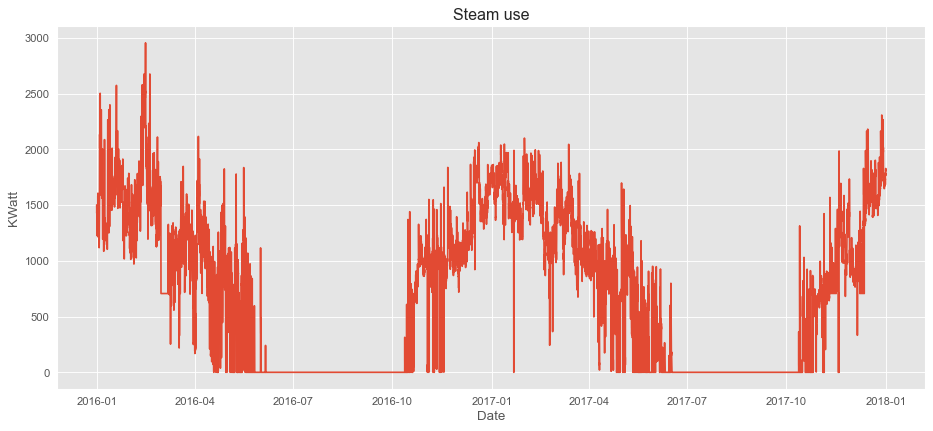

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6))
plt.plot(df.index, df.steam)
plt.title('Steam use')
plt.xlabel('Date')
plt.ylabel('KWatt')
plt.show()

In [ ]:
fig.savefig("C:\\Users\\Aida\\diploma work\\building-data-genome-project-2\\figures\\visual1.png", bbox_inches='tight')
fig.savefig("C:\\Users\\Aida\\diploma work\\building-data-genome-project-2\\figures\\visual1.png", dpi=72, bbox_inches='tight')

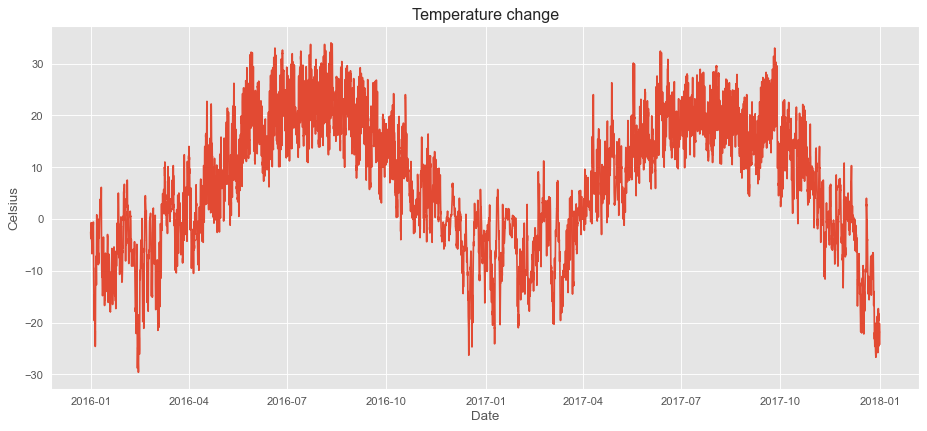

In [ ]:
figure2, ax = plt.subplots(figsize=(14, 6))
plt.plot(df.index, df.temperature)
plt.title('Temperature change')
plt.xlabel('Date')
plt.ylabel('Celsius')
plt.show()

In [ ]:
figure2.savefig("C:\\Users\\Aida\\diploma work\\building-data-genome-project-2\\figures\\tempchange.png", bbox_inches='tight')
figure2.savefig("C:\\Users\\Aida\\diploma work\\building-data-genome-project-2\\figures\\tempchange.png", dpi=72, bbox_inches='tight')

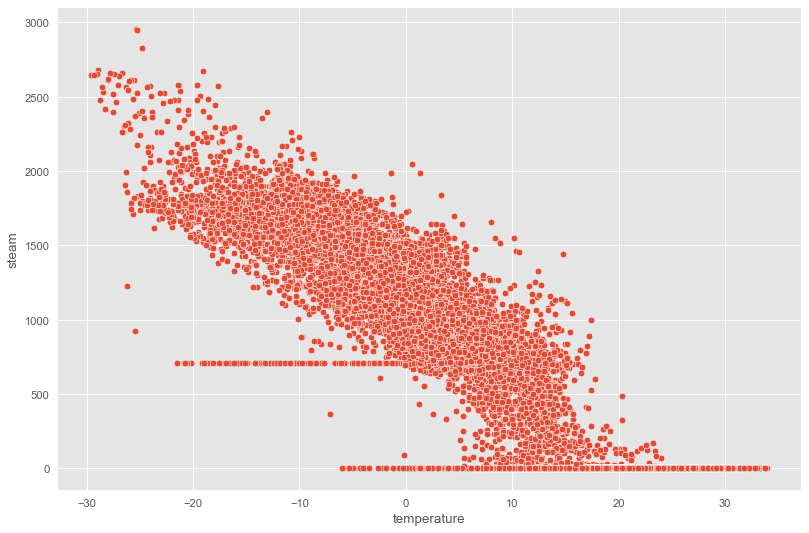

In [ ]:
plot = sns.scatterplot(x="temperature", y="steam", data=df);
figure3 = plot.get_figure()

In [ ]:
figure3.savefig("C:\\Users\\Aida\\diploma work\\building-data-genome-project-2\\figures\\steam_temp.png", bbox_inches='tight')
figure3.savefig("C:\\Users\\Aida\\diploma work\\building-data-genome-project-2\\figures\\steam_temp.png", dpi=72, bbox_inches='tight')

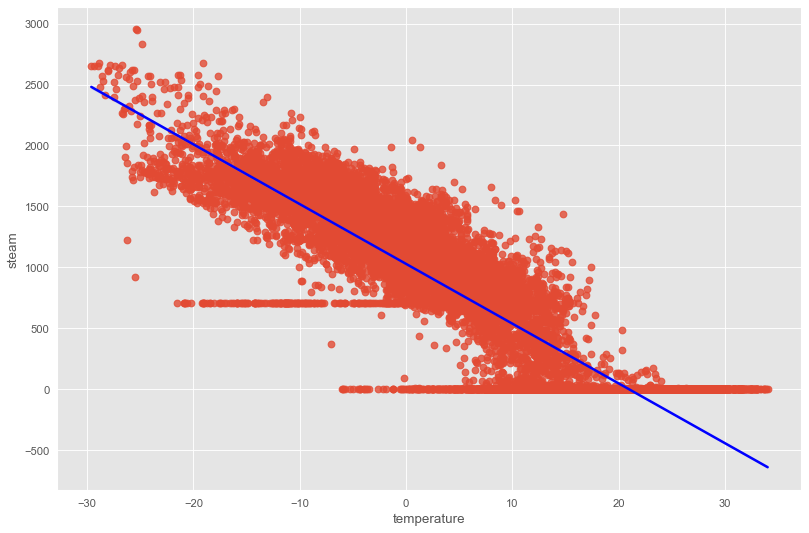

In [ ]:
plot1 = sns.regplot(x='temperature', y='steam', data=df, line_kws={'color': 'blue'})

figure4 = plot1.get_figure()

In [ ]:
figure4.savefig("C:\\Users\\Aida\\diploma work\\building-data-genome-project-2\\figures\\despine.png", bbox_inches='tight')
figure4.savefig("C:\\Users\\Aida\\diploma work\\building-data-genome-project-2\\figures\\despine.png", dpi=72, bbox_inches='tight')

In [ ]:
vis = df.copy(deep=True)
vis['year'] = vis.index.year
vis['date'] = vis['year'].map(str)+ '-' +vis['month'].map(str)
vis['date'] = pd.to_datetime(vis['date'], format='%Y-%m').dt.strftime('%Y-%m')

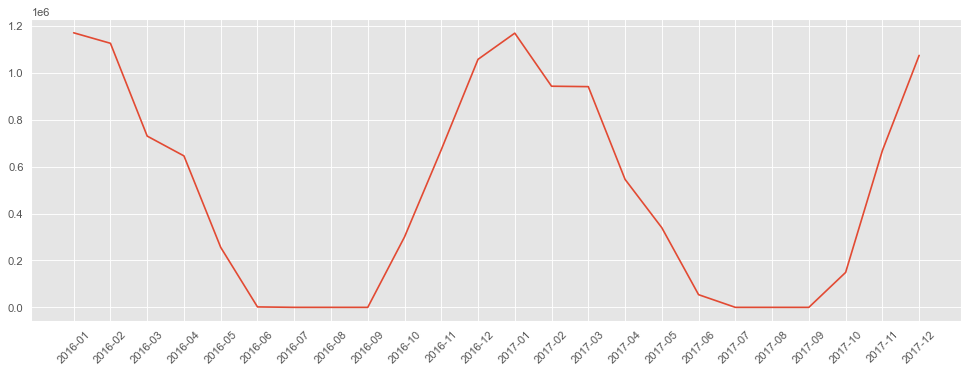

In [ ]:
figure5, ax = plt.subplots(figsize=(15, 5))
plt.plot(vis[['steam','date']].groupby(by=["date"]).sum().index, vis[['steam','date']].groupby(by=["date"]).sum().steam)
plt.xticks(rotation=45)
plt.show()

In [ ]:
figure5.savefig("C:\\Users\\Aida\\diploma work\\building-data-genome-project-2\\figures\\years.png", bbox_inches='tight')
figure5.savefig("C:\\Users\\Aida\\diploma work\\building-data-genome-project-2\\figures\\years.png", dpi=72, bbox_inches='tight')

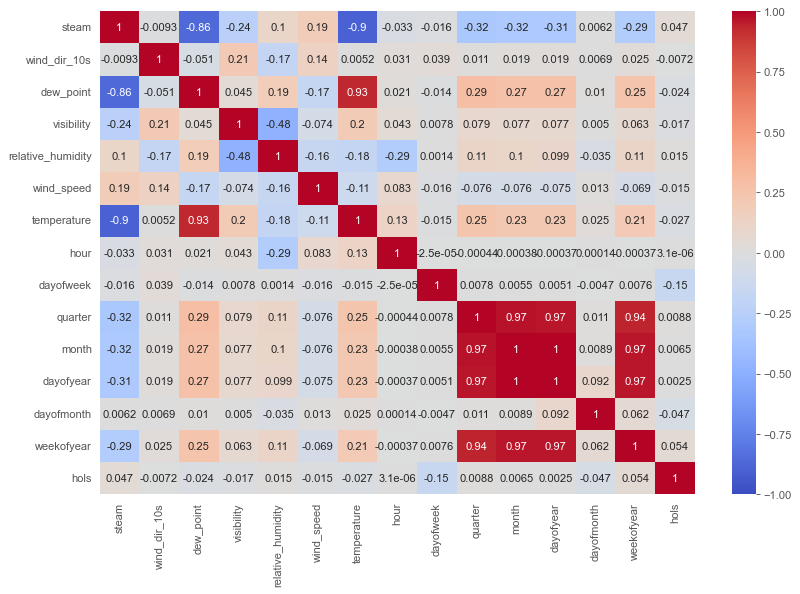

In [ ]:
# correlation
g = sns.heatmap(df.corr(), cmap="coolwarm", vmin=-1, vmax=1, annot=True)
figure7 = g.get_figure()

In [ ]:
figure7.savefig("C:\\Users\\Aida\\diploma work\\building-data-genome-project-2\\figures\\corr.png", bbox_inches='tight')
figure7.savefig("C:\\Users\\Aida\\diploma work\\building-data-genome-project-2\\figures\\corr.png", dpi=72, bbox_inches='tight')

# Random Forest Regressor

In [ ]:

df.sort_index(inplace = True)
X = df.drop(labels=['steam'], axis = 1)
y = df['steam']

X_train = X[(X.index >= '2016-01-01 00:00') & (X.index < '2017-01-01 00:00')]
X_test = X[(X.index >= '2017-01-01 00:00') & (X.index < '2018-01-01 00:00')]
y_train = y[(y.index >= '2016-01-01 00:00') & (y.index < '2017-01-01 00:00')]
y_test = y[(y.index >= '2017-01-01 00:00') & (y.index < '2018-01-01 00:00')]

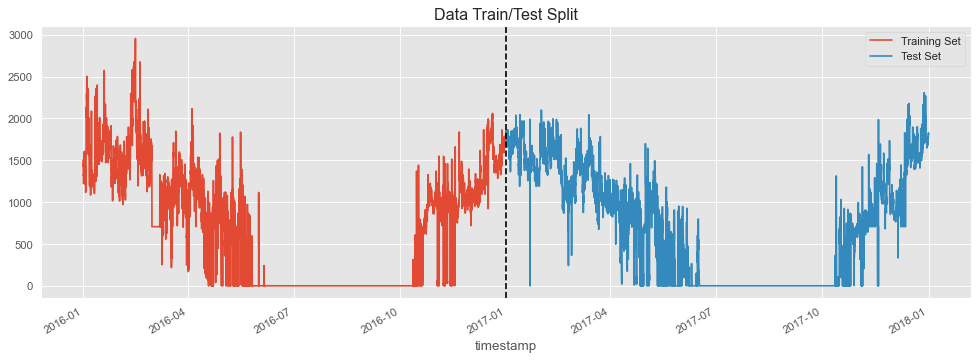

In [ ]:
figg, ax = plt.subplots(figsize=(15, 5))
y_train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
y_test.plot(ax=ax, label='Test Set')
ax.axvline(y_test.index[0], color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [ ]:
figg.savefig("C:\\Users\\Aida\\diploma work\\building-data-genome-project-2\\figures\\traintest.png", bbox_inches='tight')
figg.savefig("C:\\Users\\Aida\\diploma work\\building-data-genome-project-2\\figures\\traintest.png", dpi=72, bbox_inches='tight')

In [ ]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

mse = mean_squared_error(y_test, rf.predict(X_test))
rsq = r2_score(y_test, rf.predict(X_test))
mae = mean_absolute_error (y_test, rf.predict(X_test))


print(f'Mean Squared Error of test set: {mse:0.2f}')
print(f'Root Mean Squared Error of test set: {np.sqrt(mse):0.2f}')
print(f'R squared score of test set: {rsq:0.2f}')
print(f'Mean Absolute Error of test set: {mae:0.2f}')

Mean Squared Error of test set: 47599.25
Root Mean Squared Error of test set: 218.17
R squared score of test set: 0.89
Mean Absolute Error of test set: 126.46


# Hyper parameters

In [ ]:
rf2 = RandomForestRegressor()
prm_grid = {
    'max_depth' : [5, 6, 7],
    'max_features' : ['sqrt', 'log2'],
    'n_estimators' : [100, 200],
    'n_jobs' : [3, 4, 5]
}
rf2 = GridSearchCV(estimator = rf2, param_grid = prm_grid)
rf2.fit(X_train, y_train)

rf2.best_params_

{'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 100, 'n_jobs': 4}

In [ ]:
rf3 = RandomForestRegressor(max_features = 'log2', max_depth = 7, n_estimators = 100, n_jobs = 4)
rf3.fit(X_train, y_train)

mse = mean_squared_error(y_test, rf3.predict(X_test))
rsq = r2_score(y_test, rf3.predict(X_test))
mae = mean_absolute_error (y_test, rf3.predict(X_test))

print(f'MSE Score on Test set: {mse:0.2f}')
print(f'RMSE Score on Test set: {np.sqrt(mse):0.2f}')
print(f'R2 Score on Test set: {rsq:0.2f}')
print(f'MAE Score on Test set: {mae:0.2f}')

MSE Score on Test set: 46807.51
RMSE Score on Test set: 216.35
R2 Score on Test set: 0.89
MAE Score on Test set: 131.45


# KNN

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
knn = KNeighborsRegressor(n_neighbors=11)
knn.fit(X_train, y_train)

mse = mean_squared_error(y_test, knn.predict(X_test))
rsq = r2_score(y_test, knn.predict(X_test))
mae = mean_absolute_error (y_test, knn.predict(X_test))

print(f'MSE Score on Test set: {mse:0.2f}')
print(f'RMSE Score on Test set: {np.sqrt(mse):0.2f}')
print(f'R2 Score on Test set: {rsq:0.2f}')
print(f'MAE Score on Test set: {mae:0.2f}')

MSE Score on Test set: 65027.42
RMSE Score on Test set: 255.00
R2 Score on Test set: 0.85
MAE Score on Test set: 154.61


# KNN with MinMax Scaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
df_knn = df.copy(deep=True)

cols_to_norm = ['steam','temperature']
df_knn[cols_to_norm] = MinMaxScaler().fit_transform(df_knn[cols_to_norm])

X = df_knn.drop(labels=['steam'], axis=1)
y = df_knn['steam']

X_train = X[(X.index >= '2016-01-01 00:00') & (X.index < '2017-01-01 00:00')]
X_test = X[(X.index >= '2017-01-01 00:00') & (X.index < '2018-01-01 00:00')]
y_train = y[(y.index >= '2016-01-01 00:00') & (y.index < '2017-01-01 00:00')]
y_test = y[(y.index >= '2017-01-01 00:00') & (y.index < '2018-01-01 00:00')]

In [ ]:
knn = KNeighborsRegressor(n_neighbors= 11)
knn.fit(X_train, y_train)

mse = mean_squared_error(y_test, knn.predict(X_test))
rsq = r2_score(y_test, knn.predict(X_test))
mae = mean_absolute_error (y_test, knn.predict(X_test))

print(f'MSE Score on Test set: {mse:0.2f}')
print(f'RMSE Score on Test set: {np.sqrt(mse):0.2f}')
print(f'R2 Score on Test set: {rsq:0.2f}')
print(f'MAE Score on Test set: {mae:0.2f}')

MSE Score on Test set: 0.01
RMSE Score on Test set: 0.09
R2 Score on Test set: 0.84
MAE Score on Test set: 0.06


In [ ]:
scaler2 = MinMaxScaler()
df_elec_sc = scaler2.fit_transform(df[['steam']])

In [ ]:
y_test_knn2 = y_test.to_numpy()

In [ ]:
y_pred_knn_sc = knn.predict(X_test)
inv_y_pred = scaler2.inverse_transform(y_pred_knn_sc.reshape(-1, 1))
inv_y_test = scaler2.inverse_transform(y_test_knn2.reshape(-1, 1))

In [ ]:
mse_knn_resc = mean_squared_error(inv_y_test, inv_y_pred)
r2_knn_resc = r2_score(y_test, knn.predict(X_test))
mae_knn_resc = mean_absolute_error (inv_y_test, inv_y_pred)
print(f'MSE Score on Test set: {mse_knn_resc:0.2f}')
print(f'RMSE Score on Test set: {np.sqrt(mse_knn_resc):0.2f}')
print(f'R2 Score on Test set: {r2_knn_resc:0.2f}')
print(f'MAE Score on Test set: {mae_knn_resc:0.2f}')

MSE Score on Test set: 70699.87
RMSE Score on Test set: 265.89
R2 Score on Test set: 0.84
MAE Score on Test set: 163.72


# Feature selection

In [ ]:
from sklearn.feature_selection import SelectFromModel

In [ ]:
np.sort(rf3.feature_importances_)

array([0.00098399, 0.00168632, 0.0021267 , 0.0041488 , 0.00437123,
       0.0068325 , 0.00880607, 0.00898222, 0.03868044, 0.10848486,
       0.12172419, 0.14765913, 0.21077954, 0.33473403])

In [ ]:
col = np.array(X_train.columns)
imp = np.array(rf.feature_importances_)

df_imp = pd.DataFrame({'columns': col, 'importance': imp}, columns=['columns', 'importance'])
df_imp.sort_values('importance', ascending = False)

,columns,importance
5,temperature,0.864042
10,dayofyear,0.054022
12,weekofyear,0.019969
6,hour,0.015135
11,dayofmonth,0.010206
1,dew_point,0.010068
4,wind_speed,0.006815
9,month,0.005880
3,relative_humidity,0.003876
0,wind_dir_10s,0.003504


In [ ]:
X_train_f = X_train.drop(columns = ['quarter', 'hols', 'visibility'], axis = 1)
X_test_f = X_test.drop(columns = ['quarter', 'hols', 'visibility'], axis = 1)

In [ ]:
rf_f = RandomForestRegressor()
rf_f.fit(X_train_f, y_train)

mse = mean_squared_error(y_test, rf_f.predict(X_test_f))
rsq = r2_score(y_test, rf_f.predict(X_test_f))
mae = mean_absolute_error (y_test, rf_f.predict(X_test_f))


print(f'Mean Squared Error of test set: {mse:0.2f}')
print(f'Root Mean Squared Error of test set: {np.sqrt(mse):0.2f}')
print(f'R squared score of test set: {rsq:0.2f}')
print(f'Mean Absolute Error of test set: {mae:0.2f}')

Mean Squared Error of test set: 46948.86
Root Mean Squared Error of test set: 216.68
R squared score of test set: 0.89
Mean Absolute Error of test set: 124.99


In [ ]:
rf2_f = RandomForestRegressor()
prm_grid = {
    'max_depth' : [5, 6, 7],
    'max_features' : ['sqrt', 'log2'],
    'n_estimators' : [100, 200],
    'n_jobs' : [3, 4, 5]
}
rf2_f = GridSearchCV(estimator = rf2_f, param_grid = prm_grid)
rf2_f.fit(X_train_f, y_train)

rf2_f.best_params_

{'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 200, 'n_jobs': 4}

In [ ]:
rf3_f = RandomForestRegressor(max_features = 'sqrt', max_depth = 7, n_estimators = 200, n_jobs = 4)
rf3_f.fit(X_train_f, y_train)

mse = mean_squared_error(y_test, rf3_f.predict(X_test_f))
rsq = r2_score(y_test, rf3_f.predict(X_test_f))
mae = mean_absolute_error (y_test, rf3_f.predict(X_test_f))

print(f'MSE Score on Test set: {mse:0.2f}')
print(f'RMSE Score on Test set: {np.sqrt(mse):0.2f}')
print(f'R2 Score on Test set: {rsq:0.2f}')
print(f'MAE Score on Test set: {mae:0.2f}')

MSE Score on Test set: 0.01
RMSE Score on Test set: 0.07
R2 Score on Test set: 0.89
MAE Score on Test set: 0.04


# Within the day

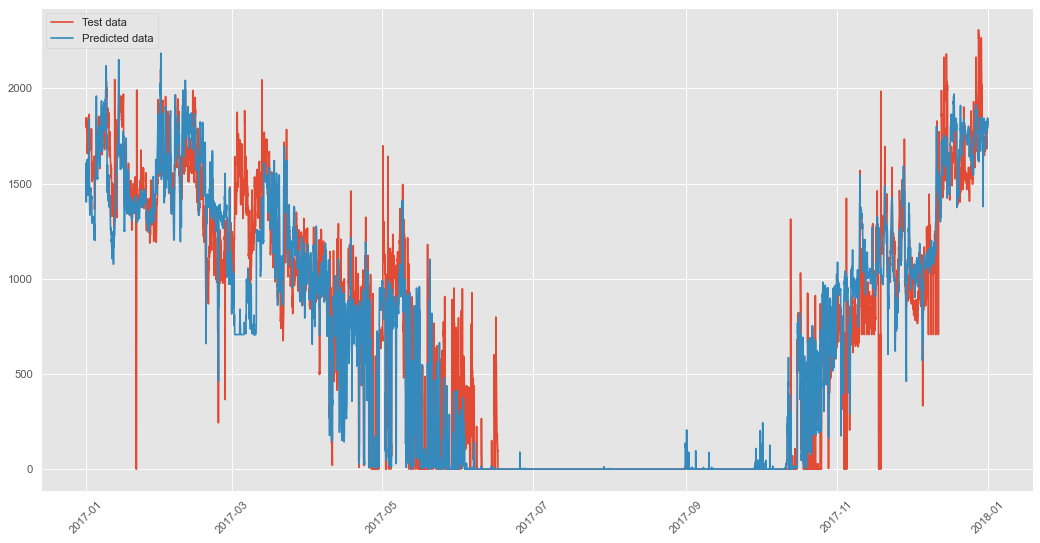

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.plot(y_test.index, y_test, label ='Test data')
plt.plot(y_test.index, rf.predict(X_test), label ='Predicted data')
plt.legend(loc="upper left")
plt.xticks(rotation=45)
plt.show()

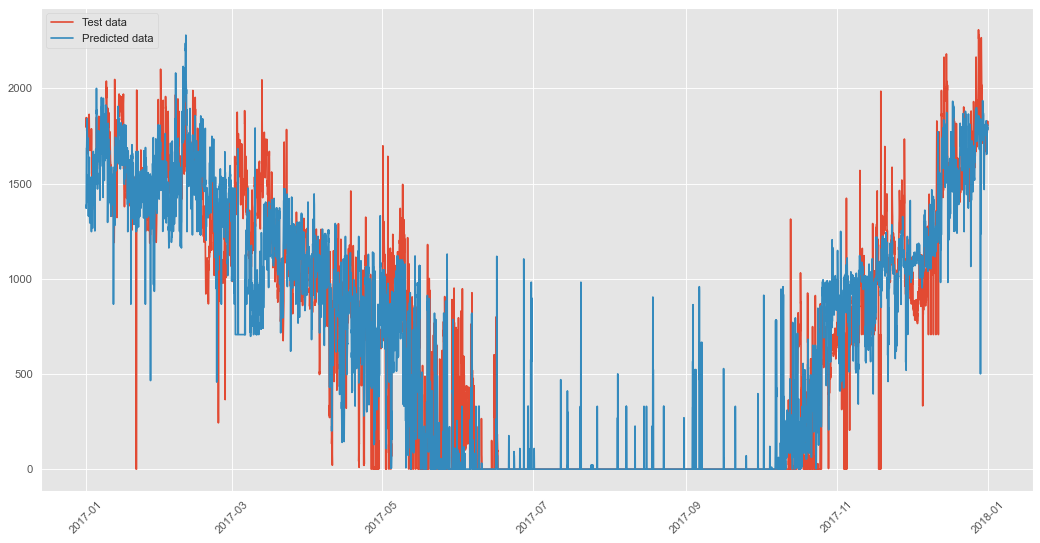

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.plot(y_test.index, y_test, label ='Test data')
plt.plot(y_test.index, knn.predict(X_test), label ='Predicted data')
plt.legend(loc="upper left")
plt.xticks(rotation=45)
plt.show()

In [ ]:
df_day = df[(df.index >= '2017-04-14 00:00') & (df.index < '2017-04-15 00:0')]

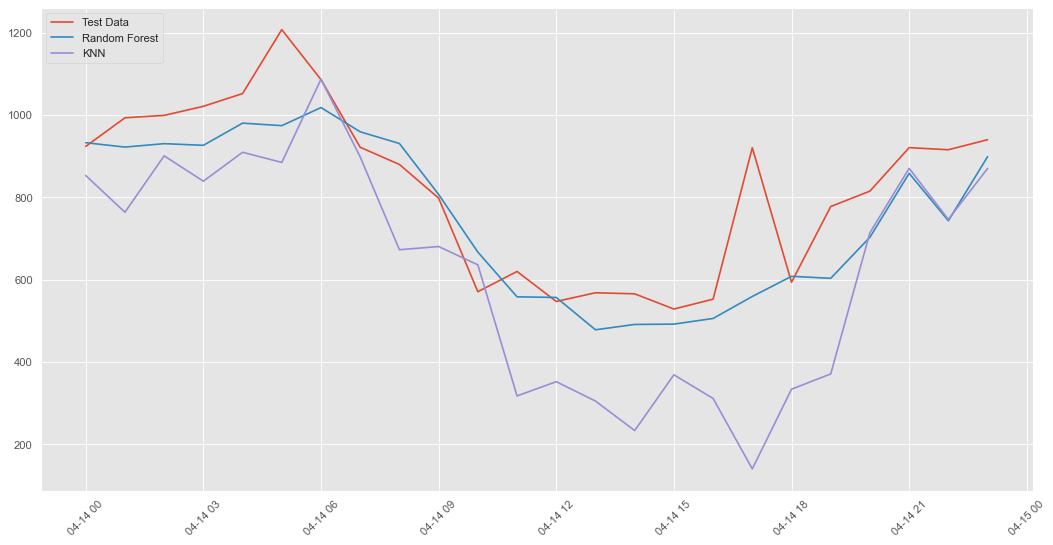

In [ ]:
figure6, ax = plt.subplots(figsize = (16, 8))
plt.plot(df_day.index, df_day['steam'], label = "Test Data")
plt.plot(df_day.index, rf3.predict(df_day.drop(columns = ['steam'], axis =1)), label = 'Random Forest')
plt.plot(df_day.index, knn.predict(df_day.drop(columns = ['steam'], axis =1)), label = 'KNN')

plt.legend(loc = "upper left")
plt.xticks(rotation =45)
plt.show()

In [ ]:
figure6.savefig("C:\\Users\\Aida\\diploma work\\building-data-genome-project-2\\figures\\days.png", bbox_inches='tight')
figure6.savefig("C:\\Users\\Aida\\diploma work\\building-data-genome-project-2\\figures\\days.png", dpi=72, bbox_inches='tight')

In [ ]:
day = df[(df.index >= '2017-12-30 00:00') & (df.index < '2017-12-31 00:0')]

In [ ]:
day_reset = day.reset_index()

In [ ]:
day_reset.to_excel('C:\\Users\\Aida\\diploma work\\day_reset.xlsx', index=False)

In [ ]:
import pickle
file_name = "steam_model.pkl"
pickle.dump(rf3, open(file_name, "wb"))